In [1]:
%matplotlib inline

from PIL import Image
import glob
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import nengo
import tensorflow as tf
import matplotlib.pyplot as plt
import nengo_dl


In /home/igr/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/igr/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/igr/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/igr/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/igr/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classi

In [2]:
xdim = 128
ydim = 96

encoding_dim = 256

list_data = glob.glob("../rgbd_dataset_freiburg1_xyz/rgb/*.png")

X_train, X_test = train_test_split(list_data, test_size=0.2, random_state=27)

n_train = len(X_train)
train_data = np.zeros((n_train,1,xdim,ydim))
for i in range(n_train):
    train_data_temp = np.array(Image.open(X_train[i]).resize((xdim,ydim)).convert('LA'))/255.
    train_data[i,0,:,:] = train_data_temp[:,:,0].T
    
n_test = len(X_test)
test_data = np.zeros((n_test,1,xdim,ydim))
for i in range(n_test):
    test_data_temp = np.array(Image.open(X_test[i]).resize((xdim,ydim)).convert('LA'))/255.
    test_data[i,0,:,:] = test_data_temp[:,:,0].T


n_in = xdim * ydim
print(train_data.shape)
print(test_data.shape)


(638, 1, 128, 96)
(160, 1, 128, 96)


In [3]:
with nengo.Network(seed = 0) as auto_net:
    
   
    input_node = nengo.Node(np.zeros(n_in))

    encoder = nengo_dl.Layer(tf.keras.layers.Dense(units=encoding_dim, activation=tf.nn.relu))(input_node)
    decoder = nengo_dl.Layer(tf.keras.layers.Dense(units=n_in, activation=tf.nn.sigmoid))(encoder)    
    
    # probes
    p_c = nengo.Probe(decoder)
    #p_c_filt = nengo.Probe(decoder.neurons, synapse=0.01, label="out_p_filt")



In [4]:
minibatch_size = 30
with auto_net:
    nengo_dl.configure_settings(stateful=False, use_loop=False)


In [5]:
with nengo_dl.Simulator(auto_net, minibatch_size=minibatch_size) as sim:
  sim.compile(optimizer = tf.optimizers.Adam(), 
              loss = {p_c: tf.losses.MSLE, },# mean squared error as loss function
                      #p_c_filt: None}
              metrics=["accuracy"]
             ) 

  # run training loop. If using spiking neurons, this converts the model to a rate based approximation and then does training
  sim.fit(train_data.reshape((-1,1,n_in)), train_data.reshape((-1,1,n_in)), epochs = 20,
          shuffle=True, validation_data=(test_data.reshape((-1,1,n_in)), test_data.reshape((-1,1,n_in))))
  print("Test error: ", sim.evaluate(test_data.reshape((-1,1,n_in)), {p_c: test_data.reshape((-1,1,n_in))}))

  output = sim.predict(test_data.reshape((-1,1,n_in))) # runs sim.predict on the first minibatch of the data 


Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               


/home/igr/.local/lib/python3.6/site-packages/nengo_dl/simulator.py:467: UserWarning: No GPU support detected. See https://www.nengo.ai/nengo-dl/installation.html#installing-tensorflow for instructions on setting up TensorFlow with GPU support.
  "No GPU support detected. See "
/home/igr/.local/lib/python3.6/site-packages/nengo_dl/simulator.py:1932: UserWarning: Number of elements in input data (160) is not evenly divisible by Simulator.minibatch_size (30); input data will be truncated.
  % (data_batch, self.minibatch_size)
/home/igr/.local/lib/python3.6/site-packages/nengo_dl/simulator.py:1932: UserWarning: Number of elements in input data (638) is not evenly divisible by Simulator.minibatch_size (30); input data will be truncated.
  % (data_batch, self.minibatch_size)


Epoch 1/20
21/21 [==============================] - 1s 30ms/step - loss: 0.0396 - probe_loss: 0.0396 - probe_accuracy: 0.0000e+00 - val_loss: 0.0278 - val_probe_loss: 0.0278 - val_probe_accuracy: 0.0000e+00
Epoch 2/20
21/21 [==============================] - 0s 22ms/step - loss: 0.0220 - probe_loss: 0.0220 - probe_accuracy: 0.0000e+00 - val_loss: 0.0186 - val_probe_loss: 0.0186 - val_probe_accuracy: 0.0000e+00
Epoch 3/20
21/21 [==============================] - 0s 23ms/step - loss: 0.0169 - probe_loss: 0.0169 - probe_accuracy: 0.0000e+00 - val_loss: 0.0153 - val_probe_loss: 0.0153 - val_probe_accuracy: 0.0000e+00
Epoch 4/20
21/21 [==============================] - 0s 23ms/step - loss: 0.0142 - probe_loss: 0.0142 - probe_accuracy: 0.0000e+00 - val_loss: 0.0133 - val_probe_loss: 0.0133 - val_probe_accuracy: 0.0000e+00
Epoch 5/20
21/21 [==============================] - 0s 23ms/step - loss: 0.0124 - probe_loss: 0.0124 - probe_accuracy: 0.0000e+00 - val_loss: 0.0121 - val_probe_loss: 0.012

In [6]:
print(output[p_c].shape)
print(test_data.shape)

(150, 1, 12288)
(160, 1, 128, 96)


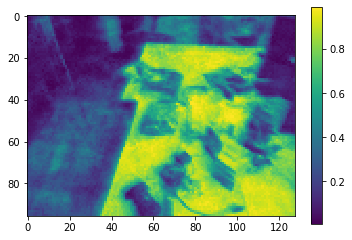

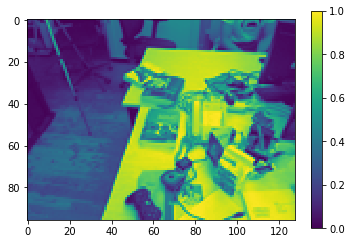

In [8]:

# display example output
plt.figure()
plt.imshow(output[p_c][0,0,:].reshape((xdim, ydim)).T, interpolation='nearest', aspect='equal')
plt.colorbar()
plt.figure()
plt.imshow(test_data[0,0,:,:].reshape((xdim, ydim)).T, interpolation='nearest', aspect='equal')
plt.colorbar();
